# Final Unit Project - Graduate School Admission Analysis
##### Matt Britton (Matthew.Britton@ga.co)
##### DAT 37 - August 5, 2016

### Import packages, load data, etc

In [1]:
#imports and setup
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn import cross_validation, linear_model, grid_search, metrics

    %matplotlib inline

/Users/mattbritton/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
#Load Data and Display
strFileName = '/Users/mattbritton/DAT-NYC-37/projects/unit-projects/project-3/assets/admissions.csv'
dfRaw = pd.read_csv(strFileName)
dfRaw.head(5)

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [3]:
#Create a new dataframe for the processed data
#Remove nulls in the GRE and GPA field (there are only 3 so no big loss)
dfClean = dfRaw[((dfRaw['gre'].isnull() == 0) & (dfRaw['gpa'].isnull() == 0))]
print(len(dfRaw) - len(dfClean), "rows w/ blanks removed")

3 rows w/ blanks removed


### Describe and explore dataset before transformation

In [4]:
#Describe and explore dataset before transformations
dfClean.describe()

,admit,gre,gpa,prestige
count,397.000000,397.000000,397.000000,397.000000
mean,0.317380,587.858942,3.392242,2.488665
std,0.466044,115.717787,0.380208,0.947083
min,0.000000,220.000000,2.260000,1.000000
25%,0.000000,520.000000,3.130000,2.000000
50%,0.000000,580.000000,3.400000,2.000000
75%,1.000000,660.000000,3.670000,3.000000
max,1.000000,800.000000,4.000000,4.000000


### Preliminary Analysis and Odds Ratios

*The heatmap below indicates a mild relationship between GRE/GPA and Admission, but nothing very strong.*

/Users/mattbritton/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


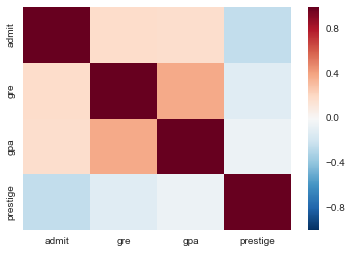

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.heatmap(dfClean.corr())

#### GRE/GPA vs Admit
*It appears that there isn't a strong direct relationship between GRE or GPA and admission. Prestige may be key.*

/Users/mattbritton/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


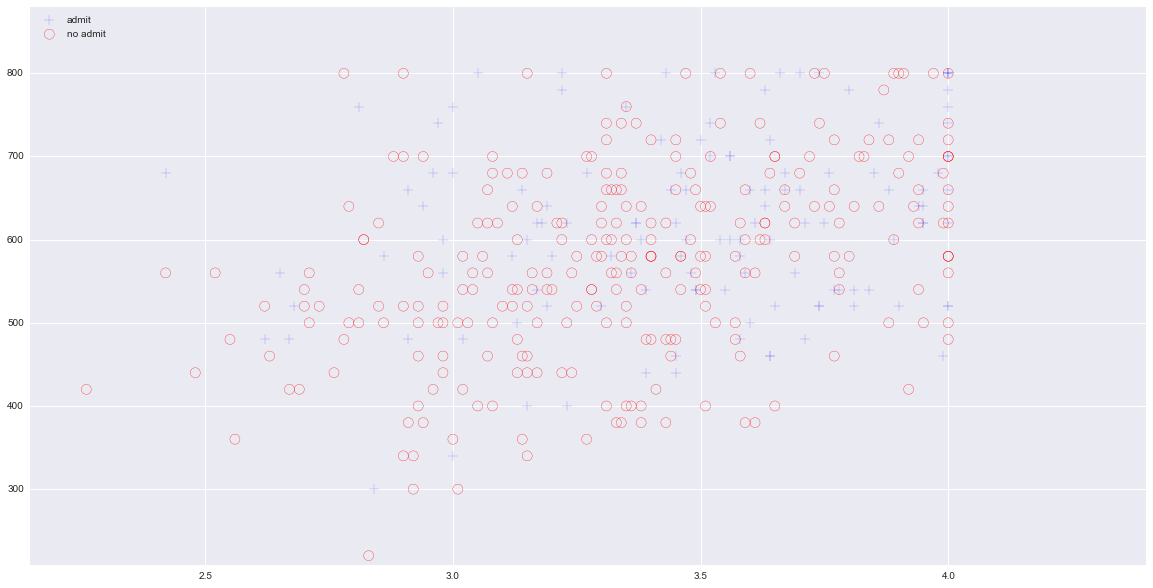

In [76]:
# Create a visual overview of GPA and GRE scores vs admit 
# as a sanity check before the regression
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    no_admit = dfClean[dfClean.admit == 0]
    admit = dfClean[dfClean.admit == 1]

    #get mins and maxes for constructing appropriate chart ranges
    dfCleanMins = dfClean.min()
    dfCleanMaxs = dfClean.max()

    plt.figure(figsize=(20,10)) 

    plt.scatter(admit.gpa, admit.gre, alpha = .5, marker='+', c= 'b', s=100)
    plt.scatter(no_admit.gpa, no_admit.gre, marker='o', edgecolors = 'r', facecolors = 'none', s=100)
    plt.xlim([0.95*dfCleanMins.loc['gpa'],1.1*dfCleanMaxs.loc['gpa']]); 
    plt.ylim([0.95*dfCleanMins.loc['gre'],1.1*dfCleanMaxs.loc['gre']]); 
    plt.legend( ('admit', 'no admit'), loc='upper left');

#### Prestige vs Admit
For students attending #1 schools, the change of being accepted is 33/61, or 54%.
For students attending #4 schools (the base case in the regression below), the chance of being accepted is 12/67, or 18%

For attendees of #1 schools, then, the odds of admission are .54/.46, or 1.17:1. 
For attendees of #4 ranked schools, the odds are .18/.82, or 0.22:1. 

The odds ratio for #1 schools vs #4 schools is 1.17/0.22, or 5.32, meaning that attendees of #1 schools are 5.32 times more likely to be admitted then attendees of #4 schools.

Clearly, Prestige is a significant predictor. 

In [7]:
pd.crosstab(index=dfRaw['admit'], columns=dfRaw['prestige'])

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,28,97,93,55
1,33,53,28,12


### Combining GPA and Prestige
*The chart below further breaks down the relationship between prestige and likelihood of admission*

In [8]:
pd.crosstab(index=dfClean['admit'], columns=dfClean['prestige'], values=dfClean['gpa'], aggfunc=np.mean)

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,3.345714,3.325895,3.402258,3.291455
1,3.544242,3.441698,3.534643,3.441667


In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    dfProcessed = pd.DataFrame(dfClean)

    #set dummy data if it hasn't already been done
    if 'prestige_1' not in dfProcessed.columns:

        #Convert prestige to an integer
        dfProcessed[['prestige']] = dfProcessed[['prestige']].astype(int)

        #Create dummy variables for the Prestige predictor
        dfTempPrestigeDummies = pd.get_dummies(dfProcessed.prestige, prefix="prestige")
        dfTempPrestigeDummies = dfTempPrestigeDummies.drop('prestige_4', 1)

        #join those new variables back into the larger dataset and drop the original column
        dfProcessed = pd.concat([dfProcessed, dfTempPrestigeDummies], axis=1)
        dfProcessed = dfProcessed.drop('prestige', 1)
    dfProcessd.head(5)

In [10]:
#Normalize GRE because the scale is much larger than the other variables
lst_X = ["gre"]
dfProcessed[lst_X] = dfProcessed[lst_X].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

In [11]:
#Create engineered feature that combines Prestige and GPA
#Initially keep all features and remove later if some don't provide any explanatory power
dfProcessed["gpa_at_prestige_1_school"] = dfProcessed["gpa"] * dfProcessed["prestige_1"]
dfProcessed["gpa_at_prestige_2_school"] = dfProcessed["gpa"] * dfProcessed["prestige_2"]
dfProcessed["gpa_at_prestige_3_school"] = dfProcessed["gpa"] * dfProcessed["prestige_3"]

dfProcessed.head()

,admit,gre,gpa,prestige_1,prestige_2,prestige_3,gpa_at_prestige_1_school,gpa_at_prestige_2_school,gpa_at_prestige_3_school
0,0,0.275862,3.61,0.0,0.0,1.0,0.0,0.0,3.61
1,1,0.758621,3.67,0.0,0.0,1.0,0.0,0.0,3.67
2,1,1.000000,4.00,1.0,0.0,0.0,4.0,0.0,0.00
3,1,0.724138,3.19,0.0,0.0,0.0,0.0,0.0,0.00
4,0,0.517241,2.93,0.0,0.0,0.0,0.0,0.0,0.00


In [12]:
#Try full feature list and see what we get
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #Apply K-Fold cross validation
    #Create feature and target dataframes for ease of manipulation
    dfX = dfProcessed.drop('admit', 1)
    serY = dfProcessed.admit

    parameter_grid = [
      {'C': list(range(1, 10))}
     ]

    regGS = grid_search.GridSearchCV(linear_model.LogisticRegression(), param_grid= parameter_grid, \
                                   cv=5, scoring='accuracy')
    regGS.fit(dfX, serY)

In [21]:
#build functions to display the regression results

def format_percentage(x):
    return "{:10.2f}%".format(100*x)

def print_regression_results(grid_search, X, y):
    
    print("***COEFFICIENTS AND PARAMETERS***", )
    
    print("Regularization hyperparameter: %d" %(grid_search.best_params_["C"]))

    regLog_coefs = {};

    for index in range(len(X.columns)):
        regLog_coefs[X.columns[index]] = grid_search.best_estimator_.coef_[0][index]

    regLog_coefs['intercept'] = grid_search.best_estimator_.intercept_[0]

    for key, value in sorted(regLog_coefs.items(), key=lambda x: x[1], reverse=True):
        print(key + ':' + "{:10.4f}".format(value))
        
    cf_matrix = metrics.confusion_matrix(y, grid_search.predict(X))
    
    print()
    print("***ACCURACY AND OTHER STATISTICS***", )

    # Accuracy
    # What % of all predictions were correct
    accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / cf_matrix.sum(dtype=float)

    # Sensitivity
    # For those who were accepted, how many did it predict correctly? 
    sensitivity = cf_matrix[1][1] / float(cf_matrix.sum(axis=1)[1])

    # Specificity
    # For those who weren't accepted, how many did it predict correctly?
    specificity = cf_matrix[0][0] / float(cf_matrix.sum(axis=1)[0])

    print("Accuracy: " + format_percentage(accuracy))
    print("Sensitivity/Recall (proportion of actual positives which are correctly identified): ", format_percentage(sensitivity))
    print("Specificity (proportion of actual negatives which are correctly identified): ", format_percentage(specificity))        

### Results of regression with lots of features
*Now try to remove some to simplify the model*

In [22]:
print_regression_results(regGS, dfX, serY)

***COEFFICIENTS AND PARAMETERS***
Regularization hyperparameter: 5
gre:    1.1888
gpa_at_prestige_1_school:    0.6126
gpa_at_prestige_2_school:    0.3612
gpa:    0.2584
gpa_at_prestige_3_school:    0.2155
prestige_2:   -0.3703
prestige_3:   -0.4996
prestige_1:   -0.5435
intercept:   -3.0877

***ACCURACY AND OTHER STATISTICS***
Accuracy:      71.03%
Sensitivity/Recall (proportion of actual positives which are correctly identified):       22.22%
Specificity (proportion of actual negatives which are correctly identified):       93.73%


In [24]:
if 'prestige_1' in dfProcessed.columns:
    
    dfProcessed.drop("gpa", axis=1, inplace = True)
    dfProcessed.drop("prestige_1", axis=1, inplace = True)
    dfProcessed.drop("prestige_2", axis=1, inplace = True)
    dfProcessed.drop("prestige_3", axis=1, inplace = True)

dfProcessed.head(5)

,admit,gre,gpa_at_prestige_1_school,gpa_at_prestige_2_school,gpa_at_prestige_3_school
0,0,0.275862,0.0,0.0,3.61
1,1,0.758621,0.0,0.0,3.67
2,1,1.000000,4.0,0.0,0.00
3,1,0.724138,0.0,0.0,0.00
4,0,0.517241,0.0,0.0,0.00


In [29]:
#Now repeat regression with simplified features and see if it performs as well
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #Apply K-Fold cross validation
    #Create feature and target dataframes for ease of manipulation
    dfX = dfProcessed.drop('admit', 1)
    serY = dfProcessed.admit

    parameter_grid = [
      {'C': list(range(1, 10))}
     ]

    regGS = grid_search.GridSearchCV(linear_model.LogisticRegression(), param_grid= parameter_grid, \
                                   cv=5, scoring='accuracy')
    regGS.fit(dfX, serY)

In [30]:
print_regression_results(regGS, dfX, serY)

***COEFFICIENTS AND PARAMETERS***
Regularization hyperparameter: 6
gre:    1.4628
gpa_at_prestige_1_school:    0.4958
gpa_at_prestige_2_school:    0.2895
gpa_at_prestige_3_school:    0.1167
intercept:   -2.5084

***ACCURACY AND OTHER STATISTICS***
Accuracy:      70.78%
Sensitivity/Recall (proportion of actual positives which are correctly identified):       22.22%
Specificity (proportion of actual negatives which are correctly identified):       93.36%


### Second Regression is an improvement
*The second regression has almost identical stats but has fewer features and is easier to interpret. GPA and Prestige seem to have little explanatory power on their own that is not achieved by the combined metric, so in the regression they just "steal" the effect of the engineered features. *

# Summary of Results

*Although the regression can predict the student's admission status with about 70% accuracy, it is far better at predicting the more common denials than the rarer admits. Only about 22% of admissions were predicted correctly. *

*The regression indicates that GRE has a positive effect on admissions chances. However, the strongest predictor is the combination of GPA and the Prestige of the school. A 0.1-point increase in GPA at a Prestige 1 school increases the likelihood of admission far more than a similar increase at a Prestige 2 school. The same comparison holds true for Prestige 2 vs 3 and 3 vs 4.*

*The takeaway then is that GPA is not a strong predictor by itself, but rather should be considered within the context of the prestige of the school.*

### Apply our regression to a sample student

In [ ]:
#Calculate a probability with sample data as a proof of concept
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def calculate_prob(coef_map, gre, gpa, prestige):
    
    #normalize GRE score based on max/min from main dataset
    gre_normalized = (coef_map['gre'] - dfClean['gre'].min())/(dfClean['gre'].max() - dfClean['gre'].min())
    
    #iterate through coefficients to generate x
    formula = coef_map['intercept'] + coef_map['gre'] * gre_normalized
    strPrestige = 'gpa_at_prestige_' + str(prestige) + '_school'
    if prestige != 4:
        formula = formula + (coef_map[strPrestige]*gpa)
    
    return sigmoid(formula)

#submit a sample student to find the likelihood of admission
gre_sample = 500
gpa_sample = 3.5
prestige_sample = 2
p_sample = calculate_prob(regLog_coefs, gre_sample, gpa_sample, prestige_sample)

print("Probability of admit for GRE=%s, GPA=%s, Prestige=%s: %s" % \
(gre_sample, gpa_sample, prestige_sample, format_percentage(p_sample)))

### Predict probabilities for all possible students 
Examine all possible combinations of the three original features

In [32]:
#Function to generate arrays of features that represent sample students
def cartesian(arrays, out=None):

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [34]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 

# 10 GPAs * 10 GREs * 4 Prestiges = 400 students

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    gres = np.linspace(dfClean['gre'].min(), dfClean['gre'].max(), 10)
    gpas = np.linspace(dfClean['gpa'].min(), dfClean['gpa'].max(), 10)


    # enumerate all possibilities
    dfCombos = pd.DataFrame(data=cartesian([gres, gpas, [1, 2, 3, 4]]), columns=['gre', 'gpa', 'prestige'])

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [39]:
#repeat preprocessing code from above to generate a dataframe in the same format as dfProcessed
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    dfProbs = pd.DataFrame(dfCombos)

    #Convert prestige to an integer
    dfProbs[['prestige']] = dfProbs[['prestige']].astype(int)

    #Create dummy variables for the Prestige predictor
    dfTempPrestigeDummies = pd.get_dummies(dfProbs.prestige, prefix="prestige")
    dfTempPrestigeDummies = dfTempPrestigeDummies.drop('prestige_4', 1)

    #join those new variables back into the larger dataset and drop the original column
    dfProbs = pd.concat([dfProbs, dfTempPrestigeDummies], axis=1)
    dfProbs = dfProbs.drop('prestige', 1)
    
    #Normalize GRE because the scale is much larger than the other variables
    lst_X = ["gre"]
    dfProbs[lst_X] = dfProbs[lst_X].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))) 

    #Create engineered feature that combines Prestige and GPA
    #Initially keep all features and remove later if some don't provide any explanatory power
    dfProbs["gpa_at_prestige_1_school"] = dfProbs["gpa"] * dfProbs["prestige_1"]
    dfProbs["gpa_at_prestige_2_school"] = dfProbs["gpa"] * dfProbs["prestige_2"]
    dfProbs["gpa_at_prestige_3_school"] = dfProbs["gpa"] * dfProbs["prestige_3"]
    dfProbs.drop("gpa", axis=1, inplace = True)
    dfProbs.drop("prestige_1", axis=1, inplace = True)
    dfProbs.drop("prestige_2", axis=1, inplace = True)
    dfProbs.drop("prestige_3", axis=1, inplace = True)

In [40]:
#create probability preduction column
dfTemp = pd.DataFrame(regGS.predict_proba(dfProbs))
dfCombos['admit_probability'] = dfTemp[[1]]

In [42]:
#Probability of each theoretical student getting admitted!
dfCombos.head()

,gre,gpa,prestige,admit_probability
0,220.0,2.260000,1,0.199749
1,220.0,2.260000,2,0.135378
2,220.0,2.260000,3,0.095805
3,220.0,2.260000,4,0.075271
4,220.0,2.453333,1,0.215514


/Users/mattbritton/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


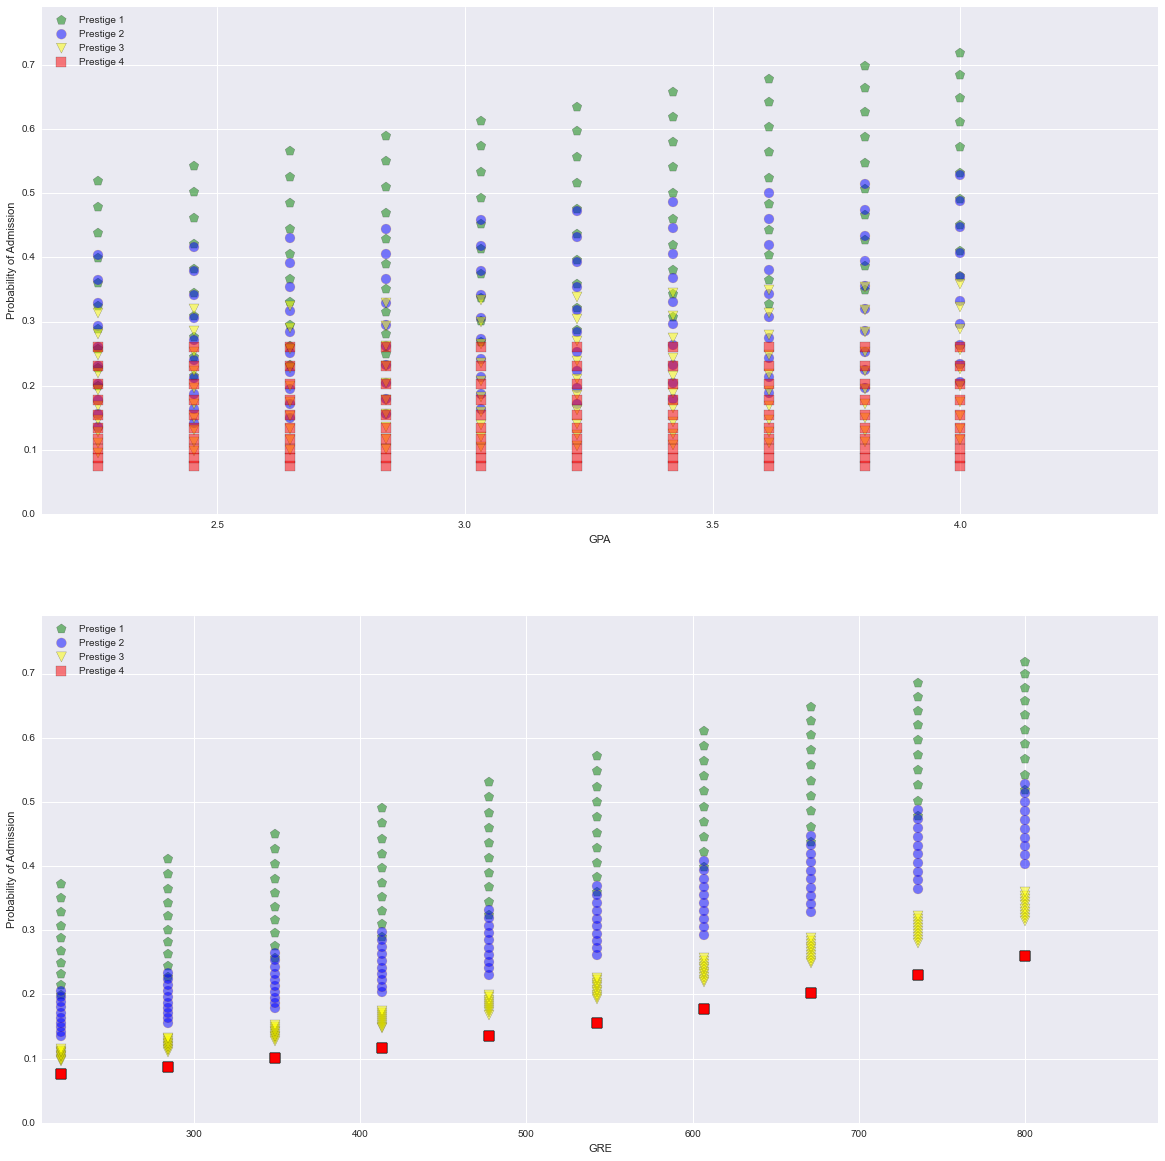

In [99]:
#plot predicted probability vs Prestige/GPA and Prestige/GRE
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    #first generate dataframes for each prestige
    dfC_P1 = dfCombos[dfCombos.prestige == 1]
    dfC_P2 = dfCombos[dfCombos.prestige == 2]
    dfC_P3 = dfCombos[dfCombos.prestige == 3]
    dfC_P4 = dfCombos[dfCombos.prestige == 4]

    plt.figure(figsize=(20,20))
    plt.subplot(211)

    plt.scatter(dfC_P1.gpa, dfC_P1.admit_probability, alpha = .5, marker='p', c= 'green', s=100)
    plt.scatter(dfC_P2.gpa, dfC_P2.admit_probability, alpha = .5, marker='o', edgecolors= 'orange', s=100)
    plt.scatter(dfC_P3.gpa, dfC_P3.admit_probability, alpha = .5, marker='v', c= 'yellow', s=100)
    plt.scatter(dfC_P4.gpa, dfC_P4.admit_probability, alpha = .5, marker='s', c= 'red', s=100)

    plt.xlim([0.95*dfCleanMins.loc['gpa'],1.1*dfCleanMaxs.loc['gpa']]); 
    plt.ylim([0, 1.1*dfCombos['admit_probability'].max()]); 
    plt.legend( ('Prestige 1', 'Prestige 2', 'Prestige 3', 'Prestige 4'), loc='upper left');
    plt.xlabel("GPA")
    plt.ylabel("Probability of Admission")

    plt.subplot(212)

    plt.scatter(dfC_P1.gre, dfC_P1.admit_probability, alpha = .5, marker='p', c= 'green', s=100)
    plt.scatter(dfC_P2.gre, dfC_P2.admit_probability, alpha = .5, marker='o', edgecolors= 'orange', s=100)
    plt.scatter(dfC_P3.gre, dfC_P3.admit_probability, alpha = .5, marker='v', c= 'yellow', s=100)
    plt.scatter(dfC_P4.gre, dfC_P4.admit_probability, alpha = .5, marker='s', c= 'red', s=100)

    plt.xlim([0.95*dfCleanMins.loc['gre'],1.1*dfCleanMaxs.loc['gre']]); 
    plt.ylim([0, 1.1*dfCombos['admit_probability'].max()]); 
    plt.legend( ('Prestige 1', 'Prestige 2', 'Prestige 3', 'Prestige 4'), loc='upper left');
    plt.xlabel("GRE")
    plt.ylabel("Probability of Admission")

## Interpretation of graphs of predicted probabilities
*These predictions indicate that even for students with GPAs and GREs at the maximum end of the spectrum, their chances of being admitted are only ~35% if they attended a prestige 3 or 4 school. The student with the highest probability of being admitted (with a 800 GRE and 4.0 GPA from a Prestige 1 school), will have about a 71% change (2.45:1 odds) of getting admitted.*

In [95]:
dfCombos[dfCombos['prestige'] == 3].tail()

,gre,gpa,prestige,admit_probability
382,800.0,3.226667,3,0.338697
386,800.0,3.420000,3,0.343767
390,800.0,3.613333,3,0.348874
394,800.0,3.806667,3,0.354015
398,800.0,4.000000,3,0.359190


In [96]:
dfCombos[dfCombos['prestige'] == 1].tail()

,gre,gpa,prestige,admit_probability
380,800.0,3.226667,1,0.635124
384,800.0,3.420000,1,0.657037
388,800.0,3.613333,1,0.678301
392,800.0,3.806667,1,0.698851
396,800.0,4.000000,1,0.718633
